In [2]:
import pandas as pd
from gensim import corpora, models, similarities
from nltk.corpus import stopwords
import re
import numpy as np
from scipy import special,stats
# import matplotlib.pyplot as plt
# %matplotlib inline 

In [3]:
f = '../../data/sherlock_current_wtext.csv'

In [3]:
data = pd.read_csv(f)

In [4]:
df = data

In [5]:
df = df.astype(str)
df = df.groupby(['Archive_Warnings', 'Author', 'Chapters', 'Characters', 'Fandoms', 'Hits', 'Kudos', 'Language', 'PublishDate',
                 'Rating','Summary', 'Title', 'Words'])['Text'].apply(','.join).reset_index()

### Run lda on texts.

In [6]:
df = df[df['Text'].astype('str').str.len() > 500]

In [7]:
df = df.drop_duplicates('Text')

In [8]:
def preprocess(df, st):
    #pre-processing
    #input: a slice of the original df
    #output: a list of lists each containing cleaned words from a work
    text = df[['Text']]
    text['Text'] = text['Text'].str.replace('A', '')
    text = text.Text.str.lower().str.split()
    text_cleaned = []
    for line in text:
        line = [re.sub(r'[^A-Za-z0-9]+', '', str(word)) for word in line]
        line = [word for word in line if len(word) > 1 and not word.isdigit() and word not in st]
        text_cleaned.append(line)
    return text_cleaned

In [9]:
def create_df_time(df, time):
    return df[df.PublishDate.str[:7] == time]

In [10]:
timelist = df.PublishDate.drop_duplicates().tolist()
timelist = [str(i)[:7] for i in timelist]
timelist = sorted(list(set(timelist)))

In [11]:
st = stopwords.words('english')

In [12]:
text = preprocess(df, st)
id2word = corpora.dictionary.Dictionary(text)
corpus = [id2word.doc2bow(t) for t in text]
lda = models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=40)

/Users/jingy/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
gamma_all = {}
kudos_all = {}
for month in timelist:
    gammas = []
    df_ts = create_df_time(df, month)
    kudos = df_ts.Kudos.astype(float).tolist()
    text = preprocess(df_ts, st)
    for i in range(len(text)):
        gammas.append(lda.get_document_topics(id2word.doc2bow(text[i]), minimum_probability = 0))
    gamma_all[month] = gammas
    kudos_all[month] = kudos

/Users/jingy/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


###Calculate KL of a work from the "standard" work.

In [30]:
def calc_kl(p, q):
    return sum([p[i]*(np.log2(p[i]/q[i])) for i in range(len(p))])

In [31]:
def return_gammas(gamma_list):
    return [i[1] for i in gamma_list]

In [32]:
def calc_std_dist(gamma_list): 
    #return average distribution of topics.
    #input:[(topic1, prob1, ...)]
    #output:[ave_prob1, ave_prob2,...]
    gamma_list_flat = []
    for i in gamma_list:
        for j in i:
            gamma_list_flat.append(j)
                    
    ave = {}
    for n in range(40):
        t = []
        for i in gamma_list_flat:
            if i[0] == n:
                t.append(i[1])
        ave[n] = sum(t)/float(len(gamma_list))

    return ave.values()

In [35]:
def calc_corr(month):
    cor_all = []
    std_dist = calc_std_dist(gamma_all.get(month))
    kls = []
    for i in gamma_all.get(month):
        gammas = return_gammas(i)
        kls.append(calc_kl(gammas, std_dist))
        
    #fill in works with no kudos with 0.
    for k in kudos_all[month]:
        if np.isnan(k):
            kudos_all[month][kudos_all[month].index(k)] = 0

    cor_all.append(stats.pearsonr(kls, kudos_all[month])[0])
    return cor_all

In [42]:
def calc_ave_kl_ts(this_month, des_month):
    std_dist = calc_std_dist(gamma_all.get(des_month))
    kls = []
    for i in gamma_all.get(this_month):
        gammas = return_gammas(i)
        kls.append(calc_kl(gammas, std_dist))
    return np.average(kls)

In [60]:
calc_ave_kl_ts('2011-05', '2011-05')

1.8781791138732227

In [43]:
def calc_ave_kl_ts_rev(this_month, des_month):
    std_dist = calc_std_dist(gamma_all.get(des_month))
    kls = []
    for i in gamma_all.get(this_month):
        gammas = return_gammas(i)
        kls.append(calc_kl(std_dist, gammas))
    return np.average(kls)

In [52]:
def calc_ave_kl_ts_inter(interval):
    kl_inter = []
    for i in range(len(timelist) - interval):
        kl_inter.append(calc_ave_kl_ts(timelist[i+interval], timelist[i]))
    kl_inter = np.average(kl_inter)
    return kl_inter

In [53]:
def calc_ave_kl_ts_neg_inter(interval):
    kl_inter = []
    timelist_r = timelist[::-1]
    for i in range(len(timelist_r) - interval):
        kl_inter.append(calc_ave_kl_ts(timelist[i+interval], timelist[i]))
    kl_inter = np.average(kl_inter)
    return kl_inter

In [54]:
def calc_ave_kl_ts_inter_rev(interval):
    kl_inter = []
    for i in range(len(timelist) - interval):
        kl_inter.append(calc_ave_kl_ts_rev(timelist[i+interval], timelist[i]))
    kl_inter = np.average(kl_inter)
    return kl_inter

In [55]:
def calc_ave_kl_ts_neg_inter_rev(interval):
    kl_inter = []
    timelist_r = timelist[::-1]
    for i in range(len(timelist_r) - interval):
        kl_inter.append(calc_ave_kl_ts_rev(timelist[i+interval], timelist[i]))
    kl_inter = np.average(kl_inter)
    return kl_inter

In [58]:
kl_inters = {}
for i in range(len(timelist)):
    kl_inters[i] = calc_ave_kl_ts_inter_rev(i)
for i in range(len(timelist)):
    kl_inters[-i] = calc_ave_kl_ts_neg_inter_rev(i)

###Plotting

###Correlation between KL and kudos

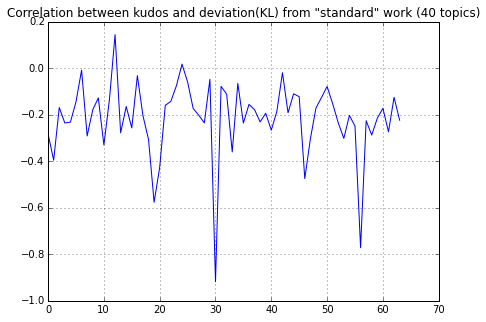

In [26]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(cor_all)
plt.grid()
ax.set_title('Correlation between kudos and deviation(KL) from "standard" work (40 topics)')

In [27]:
kl_ave = []
for month in gamma_all:
    std_dist = calc_std_dist(gamma_all.get(month))
    kls = []
    for i in gamma_all.get(month):
        kls.append(calc_kl([j[1] for j in i], std_dist))
    kl_ave.append(np.average(kls))

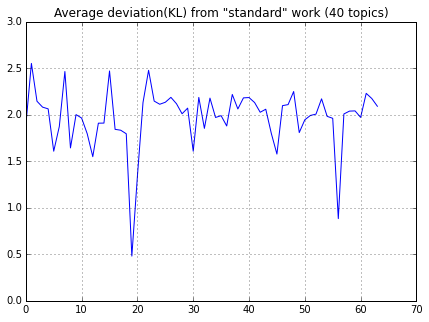

In [32]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(kl_ave)
ax.set_title('Average deviation(KL) from "standard" work (40 topics)')
plt.grid()

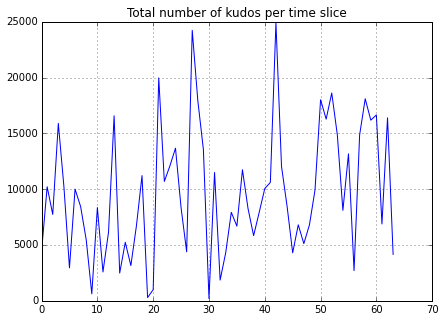

In [219]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot([sum(k) for k in kudos_all.values()])
ax.set_title('Total number of kudos per time slice')
plt.grid()

In [220]:
work_count = []
for month in timelist:
    df_ts = create_df_time(df, month)
    work_count.append(len(df_ts))

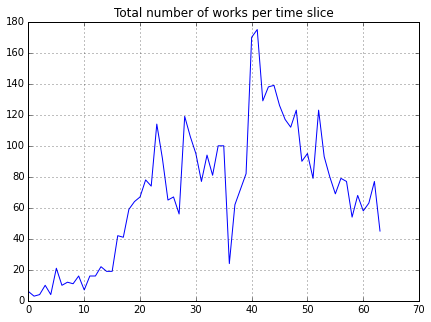

In [221]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(work_count)
ax.set_title('Total number of works per time slice')
plt.grid()

###KL over different time length

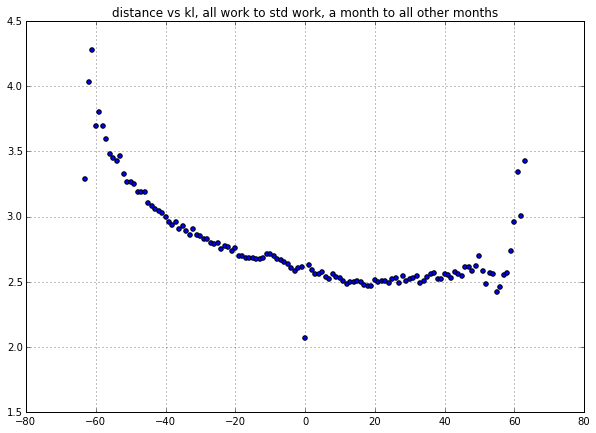

In [25]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(kl_inters.keys(), kl_inters.values())
ax.set_title('distance vs kl, all work to std work, a month to all other months')
plt.grid()

###Considering different orders because KL is asymmetric

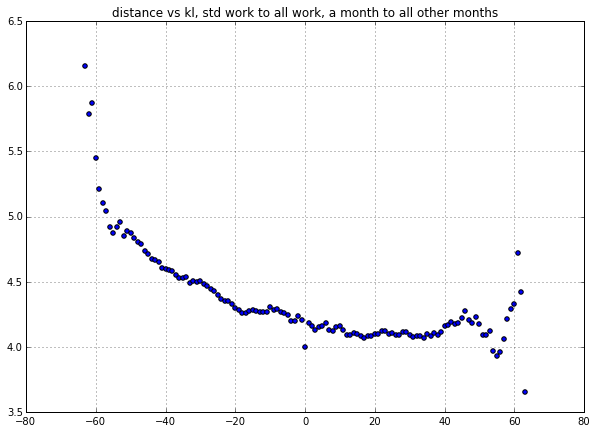

In [51]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(kl_inters.keys(), kl_inters.values())
ax.set_title('distance vs kl, std work to all work, a month to all other months')
plt.grid()

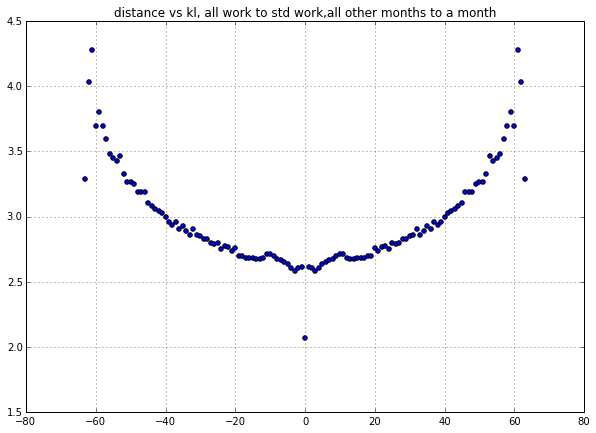

In [57]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(kl_inters.keys(), kl_inters.values())
ax.set_title('distance vs kl, all work to std work,all other months to a month')
plt.grid()

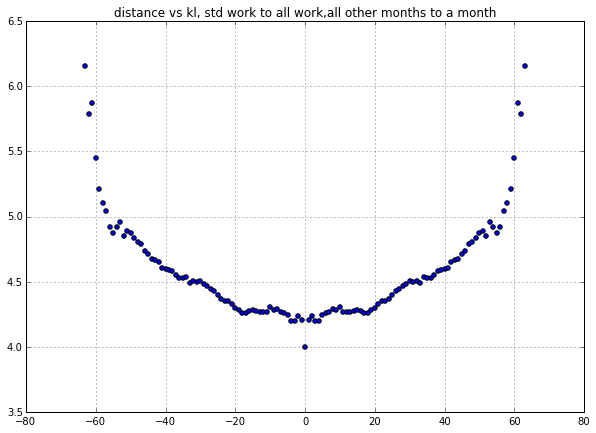

In [59]:
fig, ax = plt.subplots(figsize = (10, 7))
ax.scatter(kl_inters.keys(), kl_inters.values())
ax.set_title('distance vs kl, std work to all work,all other months to a month')
plt.grid()